In [1]:
!pip install datasets==1.14
!pip install git+https://github.com/CyberZHG/torch-same-pad.git

import torch
import torch.nn as nn
import numpy as np
import librosa as lbr
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from tqdm.notebook import tqdm
from torch_same_pad import pad

sns.set_theme()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
     |████████████████████████████████| 140 kB 60.7 MB/s 
     |████████████████████████████████| 1.1 MB 63.0 MB/s 
     |████████████████████████████████| 212 kB 70.8 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 72.8 MB/s 
     |████████████████████████████████| 144 kB 71.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/CyberZHG/torch-same-pad.git to /tmp/pip-req-build-ic5muk28
  Running command git clone -q https://github.com/CyberZHG/torch-same-pad.git /tmp/pip-req-build-ic5muk28
  Created wheel for torch-same-pad: filename=torch_same_pad-0.1.0-py3-none-any.whl size=7032 sha256=d0feb4775d021ff94d7f479162909a5f60ceab95b533028d7

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


cuda:0


In [114]:
class LaplaceOptimizer(torch.optim.Optimizer):
    """ Optimizer using diagonal of empirical Fisher & damping """
    def __init__(self, parameters, lr, damping=1.):
        super().__init__(parameters, dict(step_size=lr, damping=damping, lr=lr))

    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
              if hasattr(p, "grad"):
                if p.grad is not None:
                  if hasattr(p, "prec"):
                    p.data.add_(p.grad / (p.prec + group["damping"]), alpha=-group["step_size"])
                  else: 
                    p.data.add_(p.grad, alpha=-group["step_size"])

def taylor_operator(n=3, dt=.1, t=0, plot=False):
    """ Generalized Taylor series expansion"""
    s = np.round((t)/dt)
    k = np.asarray(range(1,n+1,1)) + np.trunc(s - (n + 1)/2)
    x = s - np.min(k) + 1

    # inverse embedding operator T: sequence = T*embedding
    T = np.zeros([n,n]) 
    for i in range(1, n+1, 1):
        for j in range(1, n+1, 1):
            T[i-1,j-1] = ((i-x)*dt)**(j-1) / np.prod(np.asarray(range(1,j,1)))

    # embedding operator E: embedding = E*sequence
    E = np.linalg.inv(np.matrix(T)) 
    if plot: 
      plt.imshow(torch.from_numpy(E).float(), cmap="Greys")
      plt.grid(False)
      plt.title(f"Taylor expansion kernel (order={n}, dt={dt})") 
      plt.show()
    return torch.from_numpy(T).unsqueeze(-1).float(), torch.from_numpy(E).unsqueeze(1).float()


def embed_data(audio, GEN_COORDS=2, dt=.1, t=0, length=100, b_size=1, input_units=1, plot=True, use_gc=True):
    """ Embed sequence into generalized coordinates """
    # embedding operator (1D convolution kernel): sequence -> embedding
    T, E = taylor_operator(n=GEN_COORDS, dt=dt, t=t)
    conv_E = torch.nn.Conv1d(1, GEN_COORDS, GEN_COORDS, stride=1, padding="valid", bias=False)  # same padding creates inaccuracies
    conv_E.weight = torch.nn.Parameter(E)

    # embed audio in generalized coordinates
    seq = torch.tensor(audio).unsqueeze(0).unsqueeze(0)
    seq = seq.reshape([length, b_size, input_units]).transpose(1,-1).transpose(0,-1).reshape([b_size*input_units,1,length])
    embedding = conv_E(seq)
    length = embedding.shape[-1]  # length might change from padding
    embedding = embedding.reshape([input_units*b_size, GEN_COORDS, length]).permute([2,0,1])
    return embedding


def embedding_batch(audios=[], phones=[], GEN_COORDS=2, dt=.5, t=0, length=100, b_size=1, input_units=1):
    """ Embed batch into generalized coordinates """
    embedding_batch, cause = [],[]
    for a, p in zip(audios, phones):
        embedding_batch.append(embed_data(a, GEN_COORDS, dt, t, length, b_size, input_units, plot=False, use_gc=True))
        cause.append(p.unsqueeze(0).repeat(embedding_batch[-1].shape[0],1,1))
    embedding_batch = torch.cat(embedding_batch)
    cause = torch.cat(cause)
    return embedding_batch*1, cause


class PCNET(nn.Module):
    """ Generalized Predictive Coding (Hierarchical Dynamical) Layer """
    def __init__(self, hidden_size=12, cause_size=61, output_size=1, dim=64, 
                 dynamical=True, activation=torch.nn.Identity(), feedthrough=False, cause_sr=100,
                 dt=1., order=4, LR_WEIGHTS=0.001, LR_STATES=0.1):
        super(PCNET, self).__init__()
        global device
        self.device = device

        # logging
        self.train = True 
        self.loss, self.loss_h, self.loss_d = [], [], []

        # state sizes
        self.hidden_size = hidden_size
        self.cause_size = cause_size
        self.output_size = output_size
        self.dim = dim

        # embedding order of hidden and cause states
        self.order = order
        self.cause_order = order
        self.dynamical = dynamical
        self.dt = dt
        self.cause_sr = cause_sr

        # learning rates
        self.LR_hidden = LR_STATES
        self.LR_cause = LR_STATES
        self.LR_TD = LR_STATES
        self.LR_weights = LR_WEIGHTS

        # weights
        self.activation = activation # nonlinearity after transition weights
        self.feedthrough = feedthrough # activation of feedthrough weights 

        # transition weights (hidden state -> hidden state)
        self.A = torch.nn.Sequential(torch.nn.Linear(self.hidden_size, self.dim, bias=False), torch.nn.ReLU(),
                                     torch.nn.Linear(self.dim, self.hidden_size, bias=False),)
        
        # input weights (cause state -> hidden state)
        self.B = torch.nn.Linear(self.cause_size, self.hidden_size, bias=False) 

        # output weights (hidden state -> response)
        self.C = torch.nn.Sequential(torch.nn.Linear(self.hidden_size, self.dim, bias=False), 
                                     torch.nn.Linear(self.dim, self.output_size, bias=False))
        
        # feedthrough weights (cause state -> response)
        self.D = torch.nn.Linear(self.cause_size, self.output_size, bias=False)

    def optimiser_weights(self):
        """ Weights optimizer """
        self.opt_weights = LaplaceOptimizer(list(self.A.parameters()) +
            list(self.B.parameters())+ list(self.C.parameters()) +
            list(self.D.parameters()), lr=self.LR_weights) 
        
    def pool_cause(self, size=10, stride=1):
        """ Mean pooling of cause along temporal (batch) dimension"""
        padded = pad(self.cause.grad.data.permute(2,1,0), size=self.cause.shape[0], kernel_size=size, stride=stride)
        pool = torch.nn.AvgPool1d(size, stride=stride)
        self.cause.grad.data = pool(padded).permute(2,1,0)

    def extrapolate(self, steps=-1, use_prediction=False):
        """ Multi-step hidden state prediction using encoded or predicted transitions """
        prediction = []
        for step, _ in enumerate(self.embedding[:steps]):
            self.apply_hidden(use_prediction=use_prediction, step=step+1)
            self.predict()
            prediction.append(self.pred_.clone().detach()[:1])
        return torch.cat(prediction)

    def apply_hidden(self, use_prediction=False, step=1):
        """ Apply the encoded or predicted hidden state motion """
        self.hidden.detach_()
        if use_prediction:
            for gc in range(self.cause_order-1):
                self.hidden[:, :, gc] = self.hidden[:, :, gc] + self.pred[:, :, gc] * self.dt
        else:
            for gc in range(self.cause_order-1):
                self.hidden[:, :, gc] = self.hidden[:, :, gc] + self.hidden[:, :, gc+1] * self.dt
 
        # step forward in observation
        self.embedding = self.embedding.clone().detach()
        self.hidden = self.hidden.clone().detach()
        self.embedding[:-1, :, :] = self.embedding.clone().detach()[1:, :, :]
        self.embedding[-1, :, :] = 0
        self.hidden[-step:] *= 0
        self.hidden.requires_grad_()

    def state_precision(self):
        """Compute precision for states using gradient variance (Laplace assumption)"""
        for param in [self.hidden, self.cause]:
            if param.grad is not None:
              param.prec = param.grad.data**2

    def weights_precision(self):
        """Compute precision of weights using gradient variance (Laplace assumption)"""
        for net in [self.A, self.B, self.C, self.D]:
            for param in list(net.parameters()):
              if param.grad is not None:
                param.prec = param.grad.data**2

    def predict(self):
        """Single prediction of hierarchical and dynamical observation"""

        if self.dynamical:
            # 1) dynamical prediction from hidden state
            self.pred = torch.cat([self.A(self.hidden[:, :, gc]).unsqueeze(0) for gc in range(self.hidden.shape[-1])]) # [x-->x', x'-->x'', ...]

            # 2) dynamical prediction from cause state
            self.pred_E = torch.cat([self.B(self.cause[:, :, gc]).unsqueeze(0) for gc in range(self.cause.shape[-1])])  # [v-->x', v'-->x'', ...]
            for gc in range(self.cause_order): 
                self.pred[gc, :, :] += self.pred_E[gc, :, :]# (v --> x') + (x --> x')
            self.pred = self.activation(self.pred.permute(1, 2, 0)) #/ self.dt

            # dynamical error
            self.error_d = self.pred[:, :, :-1] - self.hidden[:, :, 1:].detach()
        else: # static layer without hidden states
            self.error_d = torch.zeros_like(self.hidden.detach())

        # 3) hierarchical prediction from hidden state
        self.pred_ = torch.cat([self.C(self.hidden[:, :, gc]).unsqueeze(0) for gc in range(self.hidden.shape[-1])])#*0 #[x->y, x'->y', ...]

        # 4) hierarchical prediction from cause state (skip connection)
        if self.feedthrough:
            self.pred_F = torch.cat([self.D(self.cause[:, :, gc]).unsqueeze(0) for gc in range(self.cause.shape[-1])]) # [v-->y, v'-->y', ...]
            for gc in range(self.cause_order):
                self.pred_[gc, :, :] += self.pred_F[gc, :, :]  #[v->y, v'->y', ...]

        self.pred_ = self.pred_.permute(1, 2, 0)

        # hierarchical error
        self.error_h = (self.pred_[:, :, 0:] - self.embedding.detach()[:, :, 0:])

    def forward(self, steps=3, TD_cause=None, init_hidden=True, init_cause=True, learn_weights=True, apply=False, threshold=1e-5):
        """ Inference on all datapoints of an observed sequence in parallel"""

        if init_hidden:
            self.hidden = torch.zeros([self.embedding.shape[0], self.hidden_size, self.order]).to(self.device) 
            self.hidden.requires_grad_();
            self.opt_hidden = LaplaceOptimizer([self.hidden], lr=self.LR_hidden)

        if init_cause:
            self.cause = torch.zeros([self.embedding.shape[0], self.cause_size, self.order]).to(self.device)  
            if self.cause_sr == -1:
              self.cause = torch.zeros([1, self.cause_size, self.order]).to(self.device)  
            self.cause.requires_grad_();
            self.opt_cause = LaplaceOptimizer([self.cause], lr=self.LR_cause)  

        # inference: optimise states
        for step in range(steps):
            self.cause.requires_grad_()

            self.opt_cause.zero_grad()
            self.opt_hidden.zero_grad()
            self.opt_weights.zero_grad()

            # predict
            self.predict()
            (self.error_h**2).backward(gradient=torch.ones_like(self.error_h))    # gradient=self.error_h
            if self.dynamical:
                (self.error_d**2).backward(gradient=torch.ones_like(self.error_d))   # gradient=self.error_d

            # update precision
            self.state_precision()

            # normalize cause gradients
            if self.cause_sr < 0:
              self.cause.grad.data /= self.embedding.shape[0] # normalize cause grad

            if self.cause.shape[-2] > 0 and self.cause_sr > 0:
              self.pool_cause(size=self.cause_sr)
            
            # update states
            self.opt_hidden.step()
            self.opt_cause.step() 

            if step > 0 and self.train:
                self.loss.append((self.error_h.mean().abs().cpu() + self.error_d.mean().abs().cpu()).cpu().detach())
                self.loss_h.append((self.error_h.mean().abs()).cpu().detach())
                self.loss_d.append((self.error_d.mean().abs()).cpu().detach())

            # learning: optimize weights
            if learn_weights and step > 0:
                self.weights_precision()
                self.opt_weights.step()

            # update hidden states with encoded motion
            if apply:
                self.apply_hidden(step=step+1, use_prediction=False)

    def plot_embedding(self, embedding, title="", start_gc=0, ax=None):
        colors = ["blue", "orange", "green", "red", "brown", "purple", "black", "gray"]
        for gc in range(embedding.shape[-1]):
            ax.plot(embedding.detach().cpu()[:, 0, gc], label=f"GC {start_gc+gc}", color=colors[start_gc+gc])
        ax.set_xlabel("Samples");  ax.set_ylabel("Magnitude");  ax.legend(); ax.set_title(title); 

    def plot_embeddings(self, zoom=-1, title=""):
        if self.cause.shape[-2] > 0: # model has causes
          fig, axs = plt.subplots(3, 3, figsize=(8*3, 8))
        else:
          fig, axs = plt.subplots(2, 3, figsize=(8*3, 8))
        self.plot_embedding(self.pred_[:zoom, :, :], title="Hierarchical prediction", start_gc=0, ax=axs[0,0])
        self.plot_embedding(self.embedding[:zoom, :, :], title="Observation", start_gc=0, ax=axs[1,0])
        self.plot_embedding(self.pred[:zoom, :, :-1], title="Dynamical prediction", start_gc=1, ax=axs[0,1])
        self.plot_embedding(self.hidden[:zoom, :, 1:], title="Hidden state", start_gc=1, ax=axs[1,1])
        self.plot_embedding(self.error_h[:zoom, :, :], title="Hierarchical prediction error", start_gc=0, ax=axs[0,2]) 
        self.plot_embedding(self.error_d[:zoom, :, :], title="Dynamical prediction error", start_gc=1, ax=axs[1,2])
        if self.cause.shape[-2] > 0 and self.cause_sr > 0: # model has causes
          self.plot_embedding(self.cause[:zoom, :, :], title="Cause state", start_gc=0, ax=axs[2,0])
        plt.suptitle(title); plt.show()

    def plot_loss(self, w=4, title=""):
      def moving_average(x, w):
          return np.convolve(x, np.ones(w), 'same') / w
      plt.plot(moving_average(self.loss, w), label="Total prediction error", color="r")
      plt.plot(moving_average(self.loss_h, w), label="Hierarchical prediction error", color="g")
      plt.plot(moving_average(self.loss_d, w), label="Dynamical prediction error", color="b")
      plt.plot(self.loss, color="r", alpha=0.3)
      plt.plot(self.loss_h, color="g", alpha=0.3)
      plt.plot(self.loss_d, color="b", alpha=0.3)
      plt.yscale("log"); plt.legend(); plt.show()
      plt.suptitle(title)

    def plot_precision(self):
        for prec, name in zip([self.var_d, self.var_h], ["Dynamical", "Hierarchical"]):
          plt.imshow(prec.T.detach()); plt.title(f"{name} prediction error variance")
          plt.grid(False); plt.xlabel("Unit"); plt.ylabel("Order"); plt.show()


def plot_TSNE(cause):
  """Comput and plot TSNE for model causes"""
  EXAMPLES = 3000
  for layer, (data) in enumerate([cause[-EXAMPLES:,:]]): #:model.cause_size
      z = TSNE(n_components=2, init="random", learning_rate=200).fit_transform(data)
      df = pd.DataFrame()
      df["Phoneme61"] = c61[-EXAMPLES:]
      df["Phoneme39"] = c39[-EXAMPLES:]
      df["Phoneme6"] = c6[-EXAMPLES:]
      df["Speaker"] = speaker_global[-EXAMPLES:]
      df["Subject"] = np.asarray(test_subjects_global[-EXAMPLES:])
      df["1"] = z[:,0]; df["2"] = z[:,1]

  fig, axs = plt.subplots(1, 3, figsize=(8*3, 8))
  for classes, name, sel, ax in zip([c61, c39, c6], 
                                ["61", "39", "6"], ["Phoneme61", "Phoneme39", "Phoneme6"], axs):
    scatter = sns.scatterplot(data=df, x="1", y="2", hue=sel, legend=False, s=100, ax=ax, style="Subject", 
                              palette=sns.color_palette("hls", len(np.unique(classes[-EXAMPLES:]))))
    scatter.set(title=f"T-SNE ({name} phoneme classes, cross subject)"); 
    #scatter.legend(ncol=3, loc='center left', bbox_to_anchor=(1.0, 0.5))
    

In [115]:
""" TIMIT dataset"""

from datasets import load_dataset, load_metric
from IPython.display import display
timit = load_dataset("timit_asr")

# Full phoneme set with 61 classes
phone61 = ["iy", "ih", "eh", "ey", "ae", "aa", "aw", "ay", "ah", "ao", "oy", "ow", "uh", "uw", "ux", "er", "ax", "ix",
    "axr", "ax-h", "jh", "ch", "b", "d", "g", "p", "t", "k", "dx", "s", "sh", "z", "zh", "f", "th", "v", "dh", "m", "n",
    "ng", "em", "nx", "en", "eng", "l", "r", "w", "y", "hh", "hv", "el", "bcl", "dcl", "gcl", "pcl", "tcl", "kcl", "q",
    "pau", "epi", "h#"]

# Reduced phoneme set with 39 classes
phone39 = ['iy', 'ih', 'eh', 'ae', 'ah', 'uw', 'uh', 'aa', 'ey', 'ay', 'oy', 'aw', 'ow',  
    'l', 'r', 'y', 'w', 'er', 'm', 'n', 'ng', 'ch', 'jh', 'dh', 'b', 'd', 'dx', 
    'g', 'p', 't', 'k', 'z', 'v', 'f', 'th', 's', 'sh', 'hh', 'sil']
phone39map = {'ao': 'aa', 'ax': 'ah', 'ax-h': 'ah', 'axr': 'er', 'hv': 'hh',  
    'ix': 'ih', 'el': 'l', 'em': 'm', 'en': 'n', 'nx': 'n','eng': 'ng',  
    'zh': 'sh',  "ux": "uw",  "pcl": "sil",  "tcl": "sil","kcl": "sil",
    "qcl": "sil","bcl": "sil","dcl": "sil","gcl": "sil","h#": "sil",
    "#h": "sil","pau": "sil","epi": "sil","q": "sil"}

# Reduced phoneme set with 6 classes'
phone6 = ['VS', 'NF', 'SF', 'WF', 'ST', 'CL', 'SON', 'OBS']
phone6map = {'aa': 'VS', 'ae': 'VS', 'ah': 'VS', 'ao': 'VS', 'aw': 'VS', 'ax': 'VS', 'axh': 'VS', 'axr': 'VS', 'ay': 'VS', 
    'eh': 'VS', 'er': 'VS', 'ey': 'VS', 'ih': 'VS', 'ix': 'VS', 'iy': 'VS', 'ow': 'VS', 'oy': 'VS', 'uh': 'VS', 
    'uw': 'VS', 'ux': 'VS', 'el': 'VS', 'l': 'VS', 'r': 'VS', 'w': 'VS', 'y': 'VS',
    'em': 'NF', 'en': 'NF', 'eng': 'NF', 'm': 'NF', 'n': 'NF', 'ng': 'NF', 'nx': 'NF', 'dx': 'NF', 
    's': 'SF', 'z': 'SF', 'sh': 'SF', 'zh': 'SF', 'ch': 'SF', 'jh': 'SF',
    'v': 'WF', 'f': 'WF', 'dh': 'WF', 'th': 'WF', 'hh': 'WF', 'hv': 'WF',
    'b': 'ST', 'd': 'ST', 'g': 'ST', 'p': 'ST', 't': 'ST', 'k': 'ST',
    'bcl': 'CL', 'dcl': 'CL', 'gcl': 'CL', 'pcl': 'CL', 'tcl': 'CL', 'kcl': 'CL', 'epi': 'CL', 'pau': 'CL', 'h#': 'CL', '': 'CL'}

def get_phone39(phone):
  return phone39map[phone] if phone in phone39map.keys() else phone

def get_phone6(phone):
  return phone6map[phone] if phone in phone6map.keys() else phone

def get_phone(example_id=0, phoneme_id=0, normalize=False, resample=False, plot=False, sr=16000): # 44000 for smooth inputs
    phone_ = timit["train"][example_id]['phonetic_detail']['utterance'][phoneme_id]
    phone = torch.from_numpy(np.array([i == phone_ for i in phone61]).astype(np.float32))
    phone_39 = torch.from_numpy(np.array([i == get_phone39(phone_) for i in phone39]).astype(np.float32))
    phone_6 = torch.from_numpy(np.array([i == get_phone6(phone_) for i in phone6]).astype(np.float32))
    speaker = timit["train"][example_id]['speaker_id']
    start = timit["train"][example_id]['phonetic_detail']['start'][phoneme_id]
    stop = timit["train"][example_id]['phonetic_detail']['stop'][phoneme_id]
    audio = timit["train"][example_id]['audio']['array'][start:stop]
    if False:
        audio = lbr.util.normalize(audio)
    if sr != 16000:
        audio = lbr.resample(audio, orig_sr=16000, target_sr=sr)
    if plot:
        plt.plot(audio); plt.title(f"Utterance {torch.argmax(phone).item()} speaker {speaker}"); plt.show()
        display(ipd.Audio(np.asarray(audio), rate=sr)) 
    return torch.tensor(audio), phone, speaker, phone_39, phone_6

def get_speaker_phones(speaker_id, sentences=1, max_phonemes=10, start_phoneme=1):
    speaker_phones = []
    for ex in range(sentences):
        phonemes = min(max_phonemes, len(timit["train"][speaker_id*10+ex]['phonetic_detail']['utterance']))
        speaker_phones += [get_phone(example_id=speaker_id*10+ex, phoneme_id=id) for id in range(start_phoneme, phonemes, 1)]
    return speaker_phones

def batch_data_speaker(speaker_id, sentences=1, max_phonemes=10):
    speaker_phones = get_speaker_phones(speaker_id, sentences=sentences, max_phonemes=max_phonemes)
    audios = [sp[0] for sp in speaker_phones]
    phones = [sp[1] for sp in speaker_phones]
    speakers = [sp[2] for sp in speaker_phones]
    phones39 = [sp[3] for sp in speaker_phones]
    phones6 = [sp[4] for sp in speaker_phones]
    return audios, phones, phones39, phones6, speakers

Reusing dataset timit_asr (/root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/5bebea6cd9df0fc2c8c871250de23293a94c1dc49324182b330b6759ae6718f8)


  0%|          | 0/2 [00:00<?, ?it/s]

In [116]:
def run(LEARN=True, EPOCHS=1, SUBJECTS=range(1), STRIDE=1, window_length=2000,
        STEPS1=30, ITERS=2, MAX_SENTENCES=1, MAX_PHONEMES=2, max_windows=1, check=False, SCALE=1):
  """ Train or test model"""

  for epoch in range(EPOCHS):
      print("Epoch", epoch)

      # logging
      c61, c39, c6, causes, causes2, subjects, speakers = [], [], [], [], [], [], []

      for SUBJECT in tqdm(SUBJECTS):

          # get new data
          audios_speaker, phones_speaker, phones39_speaker, phones6_speaker, speaker_id = batch_data_speaker(SUBJECT, sentences=MAX_SENTENCES, max_phonemes=MAX_PHONEMES)

          # logging
          true_phones, true_phones39, true_phones6 = [], [], []
          cause1 = [[torch.zeros([1, model.cause_size, model.order-1]) for _ in range(max_windows)] for _ in range(len(audios_speaker))] # causes layer 1
          cause2 = [[torch.zeros([1, model.cause_size, model.order-1]) for _ in range(max_windows)] for _ in range(len(audios_speaker))] # causes layer 2

          for batch, (audios, p61, p39, p6) in enumerate(zip(audios_speaker, phones_speaker, phones39_speaker, phones6_speaker)):
              if check: # test with simple sine wave
                audios = (torch.sin(torch.arange(0,500,1)/10)/SCALE)
              audios = [audios*SCALE]; # adjust input scale
              p61 = [p61]; p39 = [p39]; p6 = [p6] 

              # get new audio and labels  
              embedding, phones_cause = embedding_batch(audios=audios, phones=p61, GEN_COORDS=model.order, length=audios[0].shape[0], dt=model.dt) 
              embedding = embedding[::STRIDE]

              for iter in range(ITERS):
                # update first layer
                model.embedding = embedding.to(model.device)
                model.forward(init_hidden=True, init_cause=(iter==0), steps=STEPS1, learn_weights=LEARN)
                
                #update second layer
                model2.embedding = model.cause#.detach()
                model2.forward(init_hidden=True, init_cause=(iter==0), steps=STEPS1, learn_weights=LEARN)
                model.cause = model2.pred_.detach()

              # logging
              cause1[batch][0] = model.cause.clone().detach()[..., :-1].mean(0, keepdim=True)
              cause2[batch][0] = model2.cause.clone().detach()[..., :-1].mean(0, keepdim=True)

              # logging
              true_phones.append(p61[0].argmax(-1).detach())
              true_phones39.append(p39[0].argmax(-1).detach())
              true_phones6.append(p6[0].argmax(-1).detach())
              speakers.append(speaker_id[0])

          # collect results for all subjects
          subjects += [SUBJECT for _ in range(len(cause1))]
          c61.append(np.asarray([t.item() for t in true_phones]))
          c39.append(np.asarray([t.item() for t in true_phones39]))
          c6.append(np.asarray([t.item() for t in true_phones6]))
          causes.append(torch.cat([torch.cat(seq).flatten().unsqueeze(0) for seq in cause1]).cpu().detach().numpy())
          causes2.append(torch.cat([torch.cat(seq).flatten().unsqueeze(0) for seq in cause2]).cpu().detach().numpy())

      # concatenate windows across subjects
      c61 = np.concatenate(c61,0)
      c39 = np.concatenate(c39,0)
      c6 = np.concatenate(c6,0)
      causes = np.concatenate(causes,0)
      causes2 = np.concatenate(causes2,0)
      
      if not LEARN: break

  return c61, c39, c6, causes, causes2, speakers, subjects

In [117]:
def classify_phoneme(model, causes, epochs=40, bsize=32, test_size=128, hidden_size=32, title=""):
  """ Classify phoneme classes from cause states """

  # normalize inferred cause states
  inputs = torch.from_numpy(causes[:,:])
  inputs = torch.nn.functional.normalize(inputs, p=2.0, dim=0, eps=1e-12)

  for classes, classes_size, c in zip([c61, c39, c6], 
                                      [61, 39, 6], ["b", "g", "y"]):
      
      # split into train and test set
      inputs_test, targets_test  = inputs[:test_size], torch.tensor(classes)[:test_size]
      inputs_train, targets_train = inputs[test_size:], torch.tensor(classes)[test_size:]

      # create model and train
      net = torch.nn.Sequential(
          torch.nn.Linear(model.cause_size*(model.order-1), hidden_size), #*max_windows
          torch.nn.ReLU(), torch.nn.Linear(hidden_size, classes_size))
      opt = torch.optim.Adam(net.parameters(), lr=.01)

      losses, losses_test = [], []

      for epoch in range(epochs):
        for step in range(0, len(inputs_train)-bsize, bsize):
          opt.zero_grad()
          loss = nn.CrossEntropyLoss()(net(inputs_train[step:step+bsize]), 
                                      targets_train[step:step+bsize])
          loss.backward()
          opt.step()
        losses.append(loss.detach().item())
        losses_test.append(nn.CrossEntropyLoss()(net(inputs_test), 
                                                targets_test).detach().item())

      plt.plot(losses, label=f"Train {classes_size} classes", color=c); 
      plt.plot(losses_test, label=f"Test {classes_size} classes", color=c, linestyle=":"); 

      predictions = [int(t) for t in net(inputs_train).argmax(-1)]
      true_values = [int(t) for t in targets_train]
      print(f"{classes_size} Train Accuracy", 
            (np.asarray(true_values) == np.asarray(predictions)).sum() / len(true_values))

      predictions = [int(t) for t in net(inputs_test).argmax(-1)]
      true_values = [int(t) for t in targets_test]
      print(f"{classes_size} Test Accuracy", (
          np.asarray(true_values) == np.asarray(predictions)).sum() / len(true_values))

  plt.title(f"Phoneme classification"); plt.legend();
  plt.ylabel("Cross Entropy"); plt.xlabel("Epoch"); 
  plt.suptitle(title); plt.show()



In [124]:
"""TIMIT dataset unsupervised"""

# first layer
model = PCNET(dynamical=True, hidden_size=128, cause_size=32, output_size=1, dim=128,
              order=3, dt=1, LR_WEIGHTS=.01, LR_STATES=.1, cause_sr=100,
              activation=torch.nn.Identity()).to(device)
model.optimiser_weights()

# second layer
model2 = PCNET(dynamical=True, hidden_size=128, cause_size=32, output_size=32, dim=128,
              order=3, dt=1, LR_WEIGHTS=.01, LR_STATES=.1, cause_sr=-1,
              activation=torch.nn.Identity()).to(device)
model2.optimiser_weights()

In [125]:
# train
c61, c39, c6, first_causes_global, second_causes_global, speaker_global, test_subjects_global = run(LEARN=True, 
                                                                              SUBJECTS=range(30),
                                                                              window_length = 2000, # samples per window 
                                                                              max_windows = 1, # windows per phoneme
                                                                              MAX_SENTENCES = 1, # sentences per subject
                                                                              MAX_PHONEMES = 10, # maximum phonemes per sentence
                                                                              STRIDE = 1, # input resolution
                                                                              STEPS1 = 3, # updates per pass through network
                                                                              ITERS = 2) # passes through network

Epoch 0


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


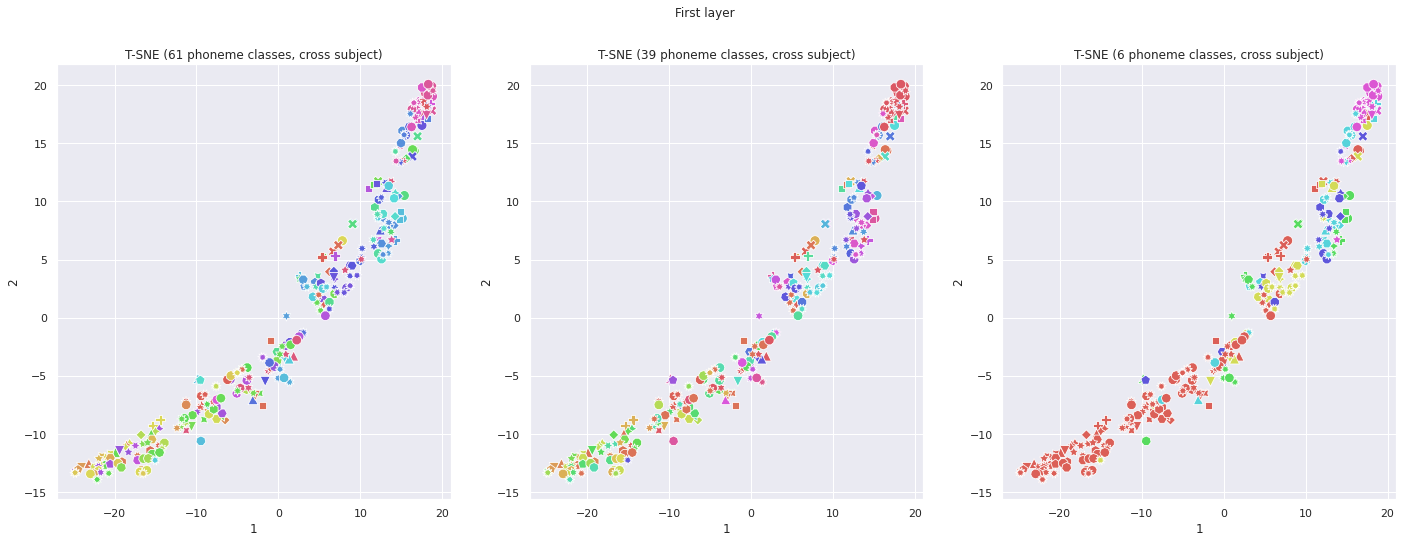

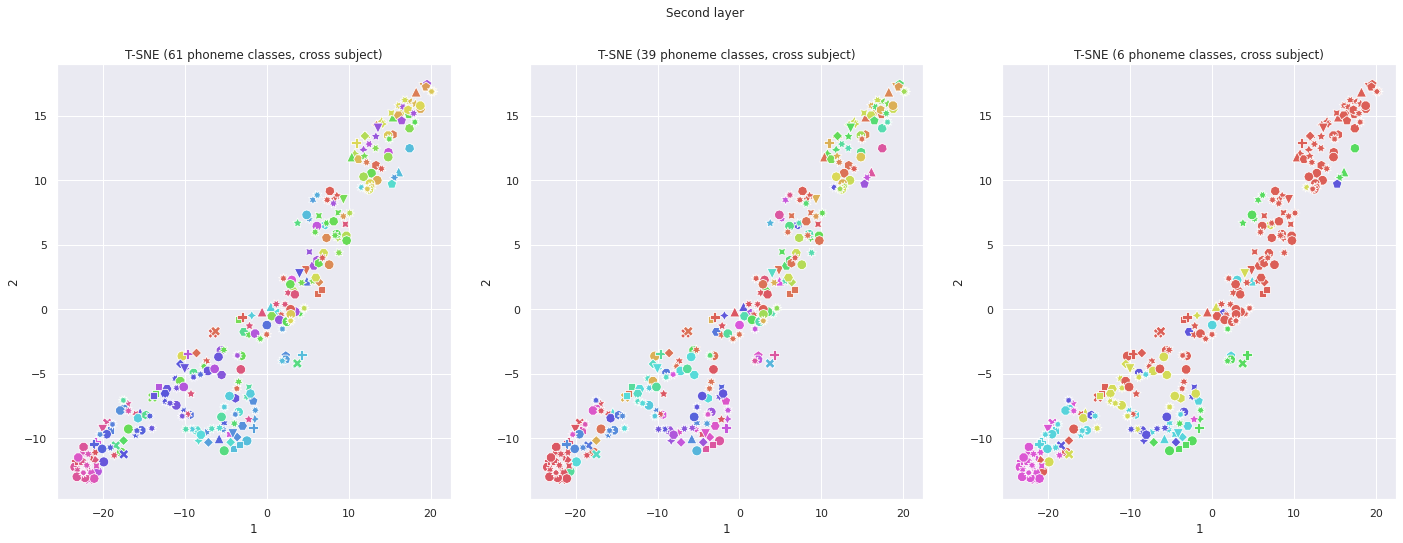

In [126]:
# TSNE for each layer
plot_TSNE(first_causes_global); plt.suptitle("First layer"); plt.show()
plot_TSNE(second_causes_global); plt.suptitle("Second layer"); plt.show()

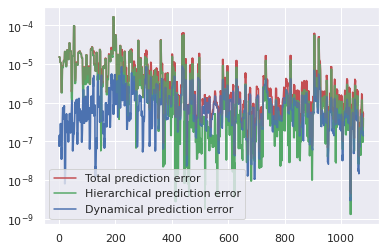

<Figure size 432x288 with 0 Axes>

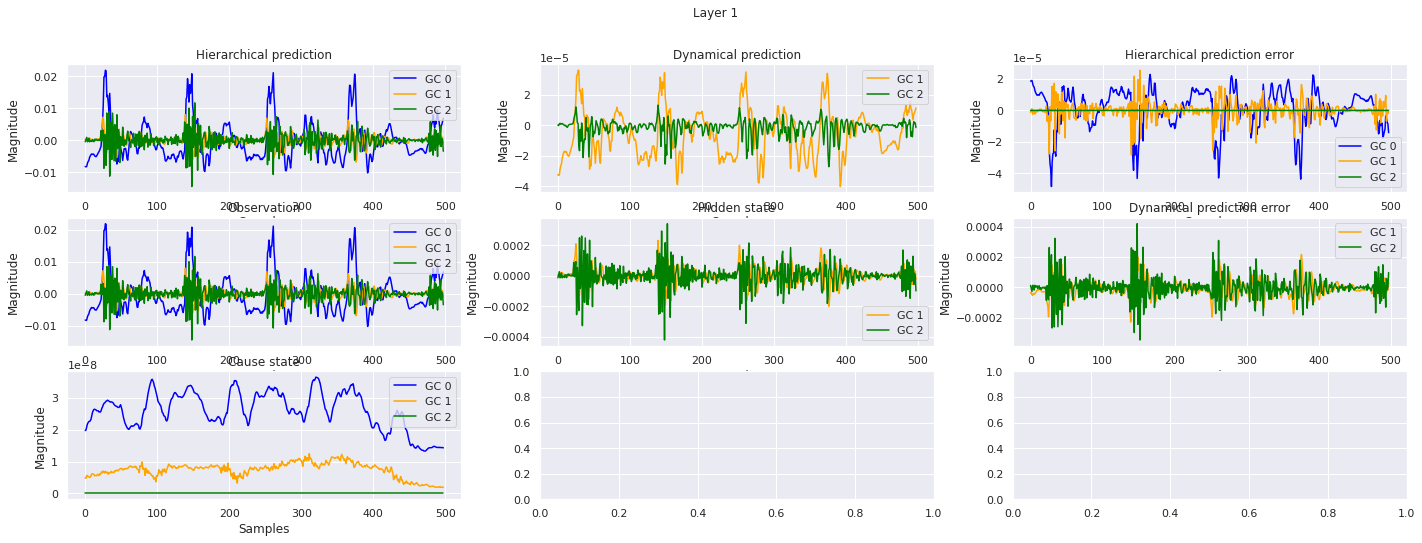

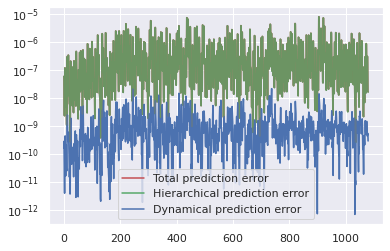

<Figure size 432x288 with 0 Axes>

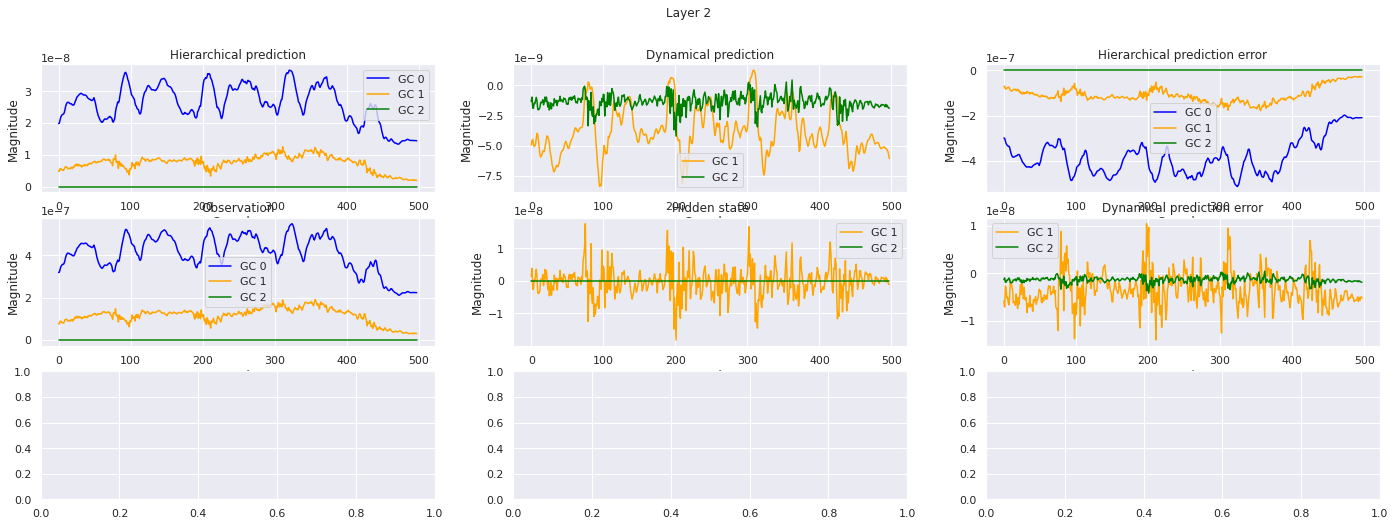

In [127]:
# First layer 
model.plot_loss(w=1, title="Layer 1")
model.plot_embeddings(zoom=-1, title="Layer 1")

# Second layer 
model2.plot_loss(w=1, title="Layer 2")
model2.plot_embeddings(zoom=-1, title="Layer 2")

Epoch 0


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


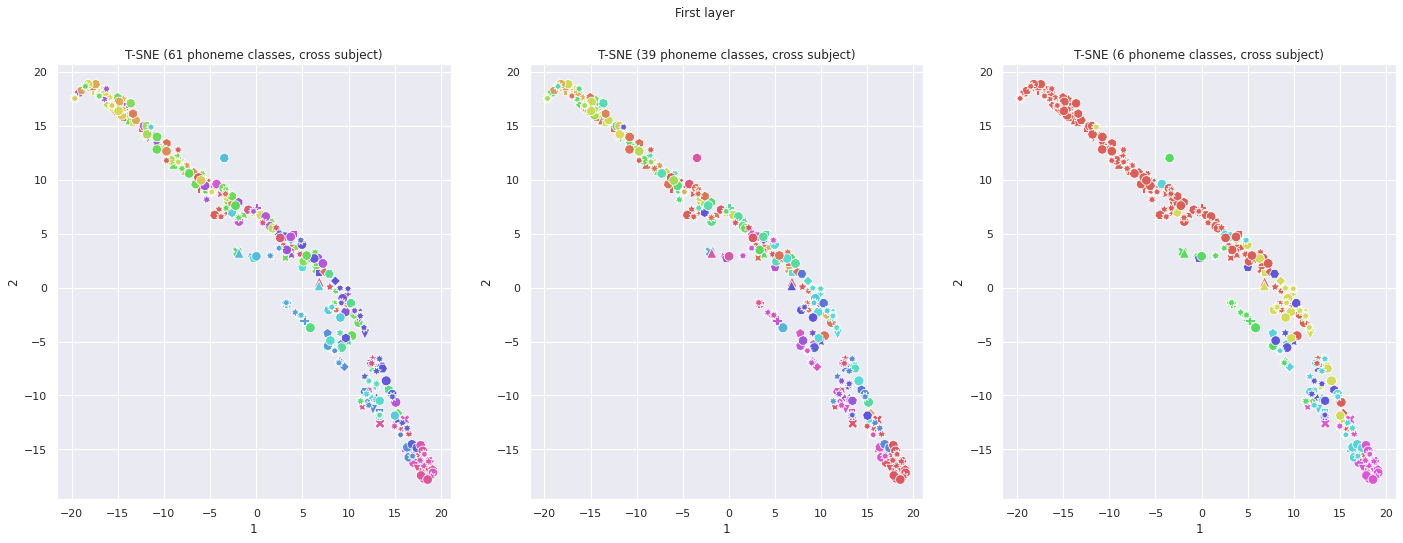

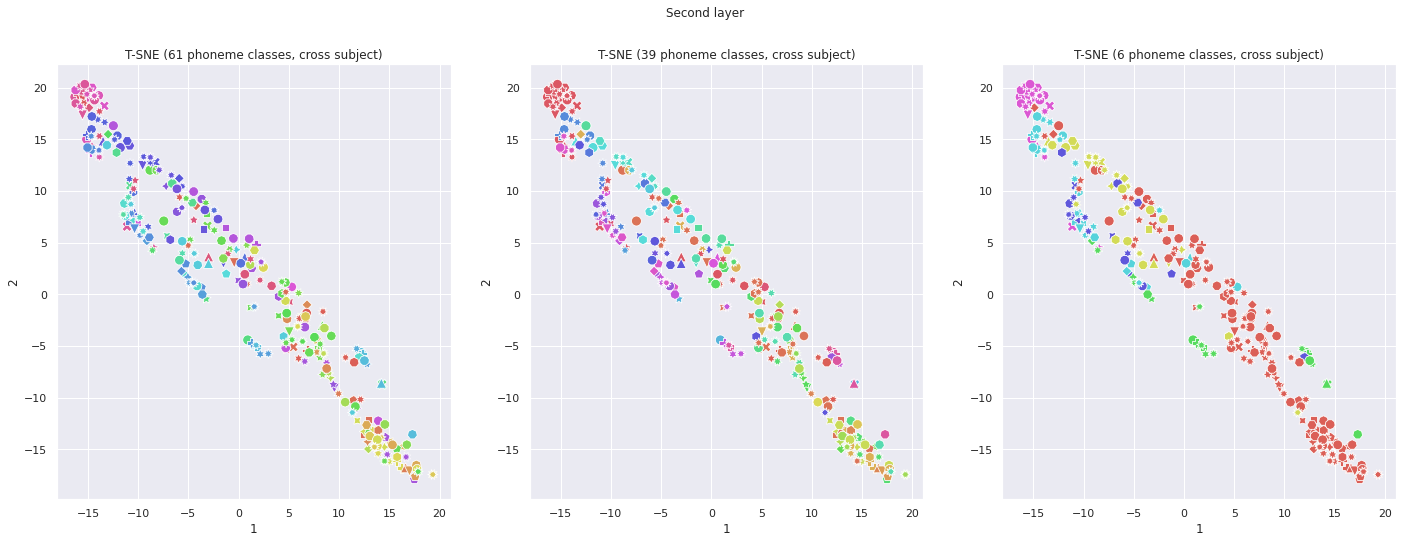

In [131]:
""" Test """

# train
c61, c39, c6, first_causes_global, second_causes_global, speaker_global, test_subjects_global = run(LEARN=False, 
                                                                              SUBJECTS=range(30),
                                                                              window_length = 2000, # samples per window 
                                                                              max_windows = 1, # windows per phoneme
                                                                              MAX_SENTENCES = 1, # sentences per subject
                                                                              MAX_PHONEMES = 10, # maximum phonemes per sentence
                                                                              STRIDE = 1, # input resolution
                                                                              STEPS1 = 3, # updates per pass through network
                                                                              ITERS = 2) # passes through network
# TSNE for each layer
plot_TSNE(first_causes_global); plt.suptitle("First layer"); plt.show()
plot_TSNE(second_causes_global); plt.suptitle("Second layer"); plt.show()

61 Train Accuracy 0.2605633802816901
61 Test Accuracy 0.1015625
39 Train Accuracy 0.2746478873239437
39 Test Accuracy 0.25
6 Train Accuracy 0.7394366197183099
6 Test Accuracy 0.7109375


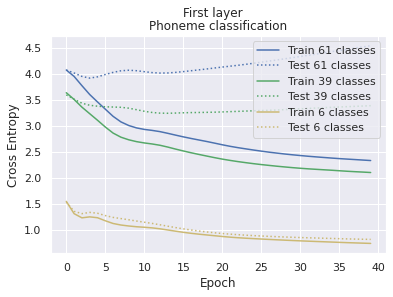

61 Train Accuracy 0.23943661971830985
61 Test Accuracy 0.1328125
39 Train Accuracy 0.2676056338028169
39 Test Accuracy 0.265625
6 Train Accuracy 0.7676056338028169
6 Test Accuracy 0.7265625


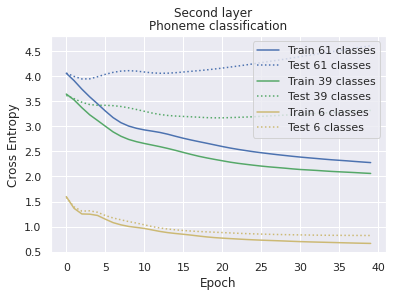

In [134]:
# Train a classifier to evaluate the representations 
classify_phoneme(model, first_causes_global, epochs=40, bsize=32, test_size=128, hidden_size=32, title="First layer")
classify_phoneme(model2, second_causes_global, epochs=40, bsize=32, test_size=128, hidden_size=32, title="Second layer")

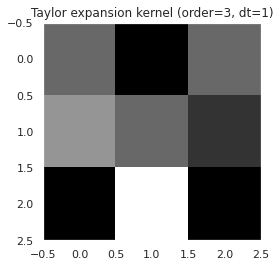

In [133]:
# Visualize Taylor expansion kernel
taylor_operator(n=model.order, dt=model.dt, t=0, plot=True);